# C-Support Vector Classification miRNA
Runs sklearn's [C-Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) on miRNA data.  

Three datasets are analyzed using the RandomForest classifier:
* Sham and infeceted mice from all weeks; i.e., 8 week and 16 week datasets are merged.
* Sham and infected mice at 8 weeks.
* Sham and infected mice at 16 weeks.

In each dataset, there is a flag (named ‘infected’) that marks whether the mice came from the infected group or the sham group.  
RandomForestClassifier's variable importance and SHAP values are then used to determine which miRNA variable was most important in each cohort dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# trying to supress sklearn warning
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import \
    RandomizedSearchCV, GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import \
    accuracy_score, f1_score, recall_score, classification_report, \
    roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

from util import \
    make_mirna_nanostring_df, make_study_df, param_search_cv, \
    param_search, plot_shap_feature_importance, plot_xgb_feature_importance, \
    combine_shap_heatmaps, plot_shap_summary, plot_shap_heatmap, \
    plot_shap_dependence, plot_shap_importance_with_summary, top_shap_values

In [4]:
! python --version

Python 3.10.12


In [5]:
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

sklearn version 1.5.2
shap version 0.46.0


---

## load miRNA data

In [6]:
file_names = [
    '../data/Fusobacterium_nucleatum/8 weeks F. nucleatum infection.csv',
    '../data/Fusobacterium_nucleatum/8 weeks SHAM infection.csv',
    '../data/Fusobacterium_nucleatum/16 weeks F. nucleatum infection.csv',
    '../data/Fusobacterium_nucleatum/16 weeks SHAM infection.csv',
    '../data/Porphyromonas_gingivalis/8 weeks P. gingivalis NanoString Data.csv',
    '../data/Porphyromonas_gingivalis/8 weeks SHAM RAW data.csv',
    '../data/Porphyromonas_gingivalis/16 weeks P. gingivalis  NanoString Data.csv',
    '../data/Porphyromonas_gingivalis/16 weeks SHAM RAW data.csv',
    '../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv',
    '../data/Streptococcus_gordonii/8 weeks SHAM infection.csv',
    '../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv',
    '../data/Streptococcus_gordonii/16 weeks SHAM infection.csv',
    '../data/Tannerella_forsythia/8 weeks T. forsythia bacteria infected mice RAW data.csv',
    '../data/Tannerella_forsythia/8 weeks SHAM RAW data.csv',
    '../data/Tannerella_forsythia/16 weeks T. forsythia bacteria infected mice RAW data.csv',
    '../data/Tannerella_forsythia/16 weeks SHAM RAW data.csv',
    '../data/Treponema_denticola/8 weeks T. denticola bacteria infected mice RAW data.csv',
    '../data/Treponema_denticola/8 weeks SHAM RAW data.csv',
    '../data/Treponema_denticola/16 weeks T. denticola bacteria infected mice RAW data.csv',
    '../data/Treponema_denticola/16 weeks SHAM RAW data.csv'
]
cohort_names = [
    'inf_fn_8_weeks', 'sham_fn_8_weeks', 'inf_fn_16_weeks', 'sham_fn_16_weeks',
    'inf_pg_8_weeks', 'sham_pg_8_weeks', 'inf_pg_16_weeks', 'sham_pg_16_weeks',
    'inf_sg_8_weeks', 'sham_sg_8_weeks', 'inf_sg_16_weeks', 'sham_sg_16_weeks',
    'inf_tf_8_weeks', 'sham_tf_8_weeks', 'inf_tf_16_weeks', 'sham_tf_16_weeks',
    'inf_td_8_weeks', 'sham_td_8_weeks', 'inf_td_16_weeks', 'sham_td_16_weeks'
]
list(zip(file_names, cohort_names))

[('../data/Fusobacterium_nucleatum/8 weeks F. nucleatum infection.csv',
  'inf_fn_8_weeks'),
 ('../data/Fusobacterium_nucleatum/8 weeks SHAM infection.csv',
  'sham_fn_8_weeks'),
 ('../data/Fusobacterium_nucleatum/16 weeks F. nucleatum infection.csv',
  'inf_fn_16_weeks'),
 ('../data/Fusobacterium_nucleatum/16 weeks SHAM infection.csv',
  'sham_fn_16_weeks'),
 ('../data/Porphyromonas_gingivalis/8 weeks P. gingivalis NanoString Data.csv',
  'inf_pg_8_weeks'),
 ('../data/Porphyromonas_gingivalis/8 weeks SHAM RAW data.csv',
  'sham_pg_8_weeks'),
 ('../data/Porphyromonas_gingivalis/16 weeks P. gingivalis  NanoString Data.csv',
  'inf_pg_16_weeks'),
 ('../data/Porphyromonas_gingivalis/16 weeks SHAM RAW data.csv',
  'sham_pg_16_weeks'),
 ('../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv',
  'inf_sg_8_weeks'),
 ('../data/Streptococcus_gordonii/8 weeks SHAM infection.csv',
  'sham_sg_8_weeks'),
 ('../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv',
  'inf_sg_16_

In [7]:
miRNA_df = make_mirna_nanostring_df(file_names, cohort_names)
miRNA_df.shape

(200, 604)

## create dataframes and X, y datasets

In [8]:
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks', infected_str='inf_')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks', infected_str='inf_')
df_all_weeks = make_study_df(miRNA_df, infected_str='inf_')

In [9]:
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']

---

## set hyperparamaters
hyperparamaters were determined using the `all_pathogens_calculate_hyperparametersall_pathogens_calculate_hyperparameters` notebook.

In [10]:
params_8_weeks =  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
 
params_16_weeks = {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

params_all_weeks =  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

---

### compute SVC models

In [11]:
model_8_weeks = SVC(**params_8_weeks).fit(X_8_weeks, y_8_weeks)
model_16_weeks = SVC(**params_16_weeks).fit(X_16_weeks, y_16_weeks)
model_all_weeks = SVC(**params_all_weeks).fit(X_all_weeks, y_all_weeks)

In [12]:
print ('model_8_weeks', 'f1 score:', f1_score(y_8_weeks, model_8_weeks.predict(X_8_weeks)))
print ('model_16_weeks', 'f1 score:', f1_score(y_16_weeks, model_16_weeks.predict(X_16_weeks)))
print ('model_all_weeks', 'f1 score:', f1_score(y_all_weeks, model_all_weeks.predict(X_all_weeks)))

model_8_weeks f1 score: 1.0
model_16_weeks f1 score: 1.0
model_all_weeks f1 score: 1.0


---

### compute SHAP values (used for explainablity)

In [13]:
explainer_8_weeks = shap.KernelExplainer(
    model_8_weeks.predict, X_8_weeks, feature_names=X_8_weeks.columns.tolist()
)
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.KernelExplainer(
    model_16_weeks.predict, X_16_weeks, feature_names=X_16_weeks.columns.tolist()
)
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

explainer_all_weeks = shap.KernelExplainer(
    model_all_weeks.predict, X_all_weeks, feature_names=X_all_weeks.columns.tolist()
)
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

100%|██████████| 100/100 [18:40<00:00, 11.20s/it]
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [2:08:10<00:00, 38.45s/it]  


---

## Bar and summary plots of feature importance

In [14]:
# shap_values_8_weeks

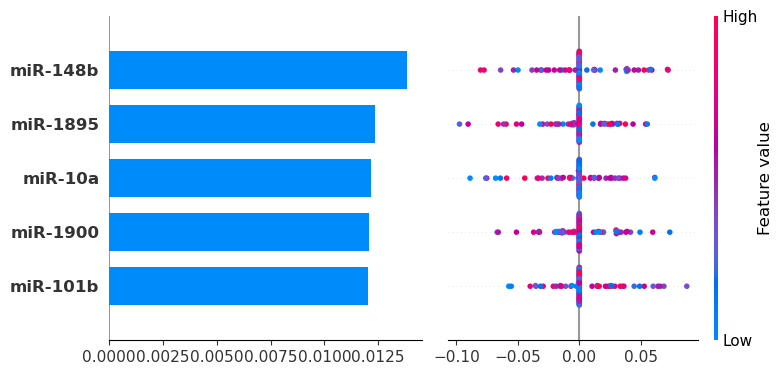

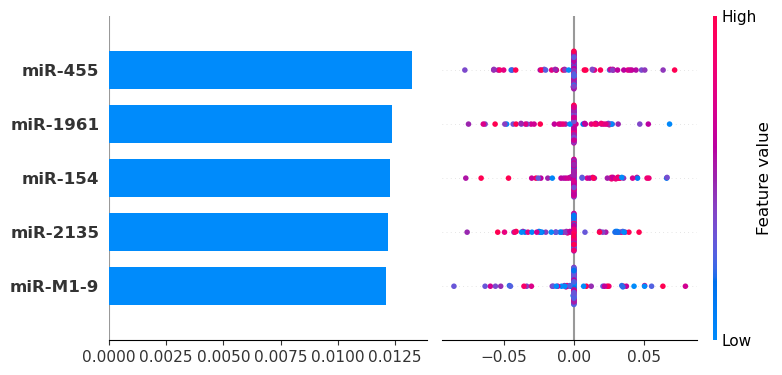

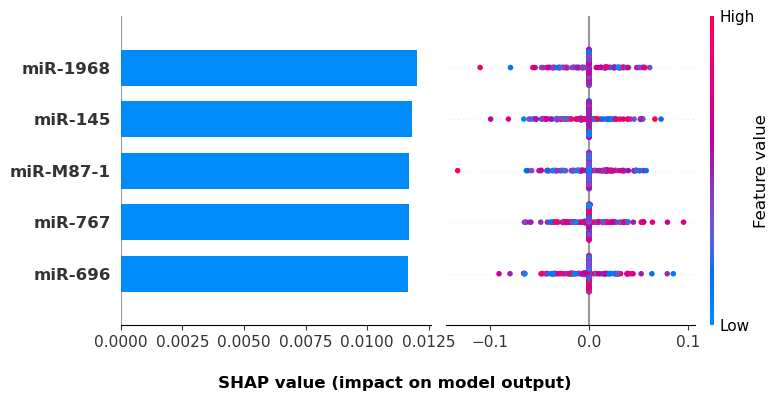

In [15]:
plot_shap_importance_with_summary(
    shap_values_8_weeks, 
    X_8_weeks, 
    title='',
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_feature_importance_with_summary_8_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_16_weeks, 
    X_16_weeks, 
    title='',
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_feature_importance_with_summary_16_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_all_weeks, 
    X_all_weeks, 
    title='',
    supxlabel = 'SHAP value (impact on model output)',
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_feature_importance_with_summary_all_weeks.png'
)

## SHAP heatmaps

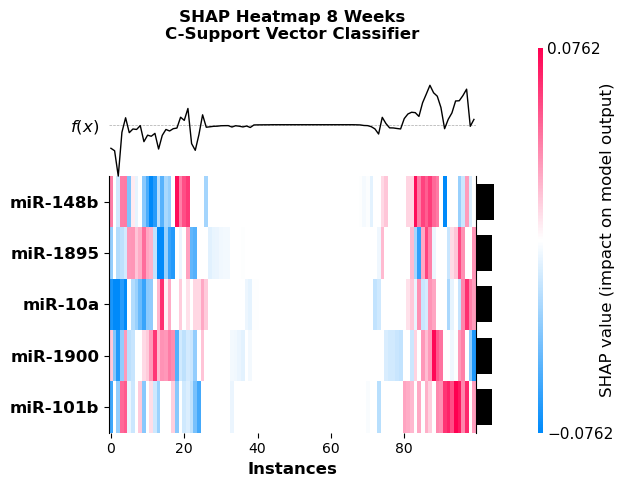

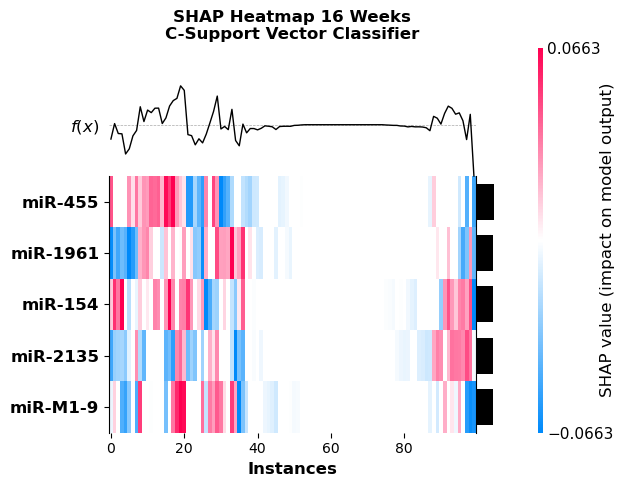

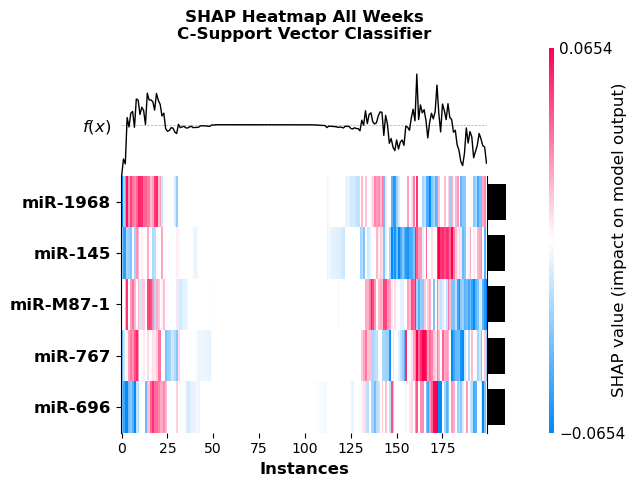

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
plot_shap_heatmap(
    top_shap_values(shap_values_8_weeks), 
    "SHAP Heatmap 8 Weeks\nC-Support Vector Classifier", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_Heatmap_8_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_16_weeks), 
    "SHAP Heatmap 16 Weeks\nC-Support Vector Classifier", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_Heatmap_16_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_all_weeks), 
    "SHAP Heatmap All Weeks\nC-Support Vector Classifier", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_Heatmap_All_Weeks.png'
)

## SHAP dependence plots

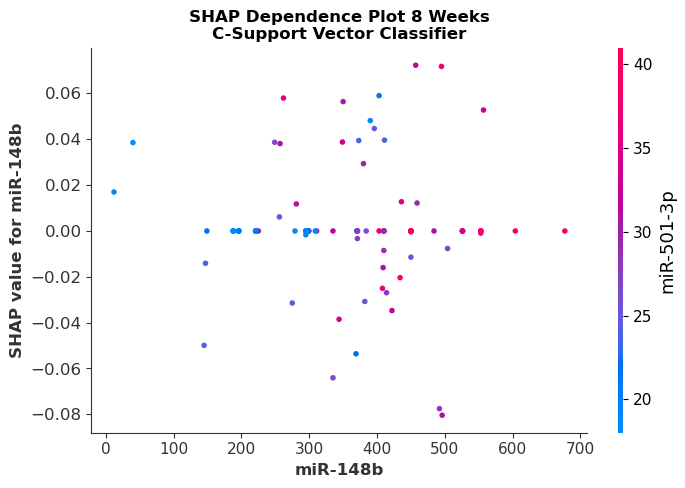

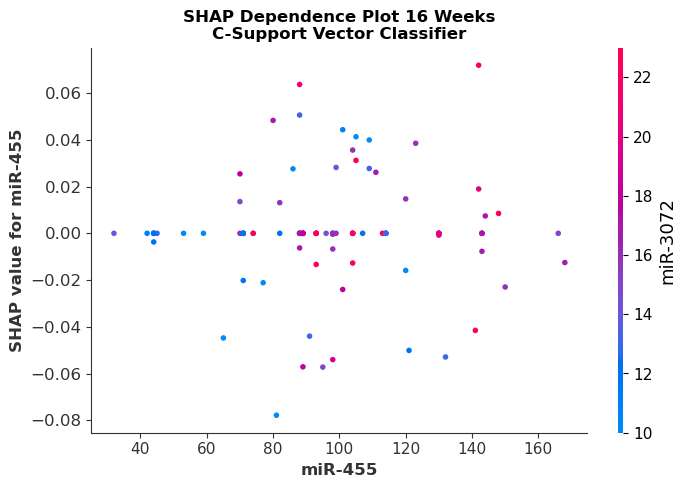

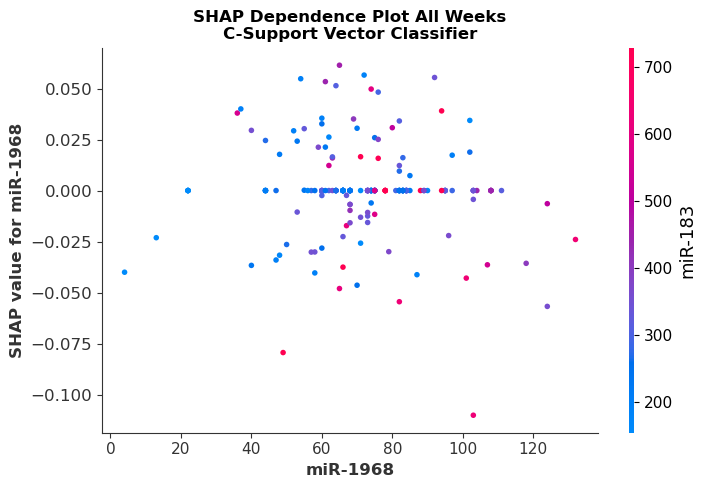

In [17]:
plot_shap_dependence(
    shap_values_8_weeks, 
    X_8_weeks, 
    "SHAP Dependence Plot 8 Weeks\nC-Support Vector Classifier", 
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_Dependence_Plot_8_Weeks.png'
)

plot_shap_dependence(
    shap_values_16_weeks, 
    X_16_weeks, 
    "SHAP Dependence Plot 16 Weeks\nC-Support Vector Classifier", 
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_Dependence_Plot_16_Weeks.png'
)

plot_shap_dependence(
    shap_values_all_weeks, 
    X_all_weeks, 
    "SHAP Dependence Plot All Weeks\nC-Support Vector Classifier", 
    save_fig=True,
    file_name='all_pathogen_svc_SHAP_Dependence_Plot_All_Weeks.png'
)